# SD201 Project 

## Dataset (from a Kaggle competition) : Instacart Market Basket Analysis

Link : https://www.kaggle.com/c/instacart-market-basket-analysis/data

Blog post about the competition : https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2

Key points from the dataset:

- 3M grocery store orders
- 200,000+ Instacart users
- 4 to 100 orders for each user, timestamped

“The Instacart Online Grocery Shopping Dataset 2017”, Accessed from https://www.instacart.com/datasets/grocery-shopping-2017 on 10/12/2021"

## Introduction

In this project, we seek to predict the next basket items for a client given a history of past orders. This is a multi-label classification problem.

Auxiliary questions :

- relation between item categories and associations (Apriori algorithm) ?
- clustering of aisles/departments ?

In [138]:
'''Python librairies''' 

# Utility librairies
import pandas as pd
import scipy.stats as s
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# Pretty charts
import seaborn as sns
sns.set_theme(style="ticks")

In [4]:
aisles = pd.read_csv('./instacart/aisles.csv')
departments = pd.read_csv('./instacart/departments.csv')
op_prior = pd.read_csv('./instacart/order_products__prior.csv')
op_train = pd.read_csv('./instacart/order_products__train.csv')
orders = pd.read_csv('./instacart/orders.csv')
products = pd.read_csv('./instacart/products.csv')
sample_submission = pd.read_csv('./instacart/sample_submission.csv')

## Exploratory data analysis 

### Description of the dataset 

`aisles` : the different aisles of the Instacart platform.

In [3]:
aisles.head()

aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation

`departments` : departments for the products.

In [4]:
departments

department_id       department
0               1           frozen
1               2            other
2               3           bakery
3               4          produce
4               5          alcohol
5               6    international
6               7        beverages
7               8             pets
8               9  dry goods pasta
9              10             bulk
10             11    personal care
11             12     meat seafood
12             13           pantry
13             14        breakfast
14             15     canned goods
15             16       dairy eggs
16             17        household
17             18           babies
18             19           snacks
19             20             deli
20             21          missing

`op_prior` and `op_train` are the orders that shall be used as training and testing sets respectively. In the competition, we make predictions for the `test` set, but we can check that our model works with the `train` set.

In those DataFrames, `add_to_cart_order` indicates if for a given order, the product was added first, second, etc.

`reordered` indicates if the product has already been ordered by the user making the order (1 if `True`, else 0).

`op_prior` contains all past orders with the correponding products for all clients.

In [5]:
op_prior.head()

order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0

`orders` contains all the orders of the dataset, including :

- which user ordered (`user_id`)
- which set the row belongs to : prior, train or test (`eval_set`)
- information about the number of orders they have already completed (`order_number`)
- on which day of the week they ordered (`order_dow`) and hour of the day (`order_hour_of_day`)
- and how many days have elapsed since the last order (`days_since_prior_order`) 

In [6]:
orders.head()

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0

`products` contains the name of each product, as well as which aisle and department it belongs to.

In [7]:
products.head()

product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id  
0             19  
1             13  
2              7  
3              1  
4             13

`sample_submission` gives an example of how to format the response (for the competition).

###### From the Kaggle competition :

For each orderid in the test set, you should predict a space-delimited list of productids for that order. If you wish to predict an empty order, you should submit an explicit 'None' value. You may combine 'None' with product_ids. The spelling of 'None' is case sensitive in the scoring metric. The file should have a header and look like the following:

In [8]:
sample_submission.head()

order_id     products
0        17  39276 29259
1        34  39276 29259
2       137  39276 29259
3       182  39276 29259
4       257  39276 29259

### Data exploration

Let's take a closer look at our data.

First let's examine the `orders` file.

The code for charts is given once as example and then hidden to save space.

Since the data is already split into training and testing data, we can first wonder what is the fraction of train, test, and prior data?

In [9]:
counts = orders.eval_set.value_counts()
print(counts)
total = len(orders)
print('Train fraction:', counts[1]/total)
print('Test fraction:',  counts[2]/total)
print('Prior fraction:', counts[0]/total)

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64
Train fraction: 0.03835305954284067
Test fraction: 0.021922882315336987
Prior fraction: 0.9397240581418224


Here we train our model using the prior data, and make predictions for the test data.

On which day of the week do people usually order on Instacart?

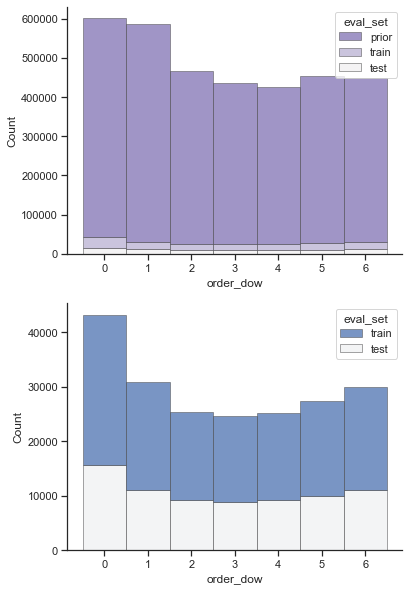

In [10]:
fig, axes = plt.subplots(2,1,figsize=(6, 10))
sns.despine(fig)

unique_dow = len(orders.order_dow.unique())+1

# Counting order_dow for all prior, train, and test sets
sns.histplot(
    orders,
    x="order_dow",
    stat="count",
    hue="eval_set",
    multiple="stack",
    bins=np.arange(unique_dow)-.5,
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    ax=axes[0]
)

# Counting order_dow for train and test sets only
sns.histplot(
    orders[orders.eval_set != "prior"],
    x="order_dow",
    stat="count",
    hue="eval_set",
    multiple="stack",
    bins=np.arange(unique_dow)-.5,
    palette="light:b_r",
    edgecolor=".3",
    linewidth=.5,
    ax=axes[1]
)

plt.show()

People seem to order more on days 0 and 1, which we may assume correspond to weekends (the dataset does not give us this data).

When do people usually place their order in the day?

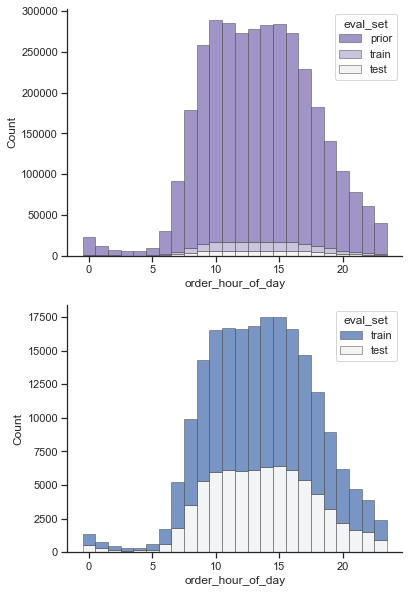

In [11]:
fig, axes = plt.subplots(2,1,figsize=(6, 10))
sns.despine(fig)

unique_hours = len(orders.order_hour_of_day.unique())+1

# Counting order_hour_of_day for all prior, train, and test sets
sns.histplot(
    orders,
    x="order_hour_of_day",
    stat="count",
    hue="eval_set",
    multiple="stack",
    bins=np.arange(unique_hours)-.5,
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    ax=axes[0]
)

# Counting order_hour_of_day for train and test sets only
sns.histplot(
    orders[orders.eval_set != "prior"],
    x="order_hour_of_day",
    stat="count",
    hue="eval_set",
    multiple="stack",
    bins=np.arange(unique_hours)-.5,
    palette="light:b_r",
    edgecolor=".3",
    linewidth=.5,
    ax=axes[1]
)

axes[0].xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
axes[1].xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

plt.show()

Most people seem to order between 10 am and 4 pm. We notice that the distribution seems to be gaussian, so we could try standardizing this columns before training our models.

At which frequency do people order on Instacart?

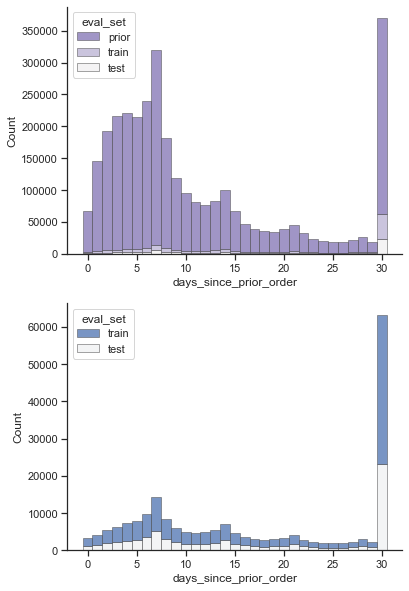

In [12]:
fig, axes = plt.subplots(2,1,figsize=(6, 10))
sns.despine(fig)

unique_dspo = len(orders.days_since_prior_order.dropna().unique()) + 1

# Counting days_since_prior_order for all prior, train, and test sets
sns.histplot(
    orders,
    x="days_since_prior_order",
    stat="count",
    hue="eval_set",
    multiple="stack",
    bins=np.arange(unique_dspo)-.5,
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    ax=axes[0]
)

# Counting days_since_prior_order for train and test sets only
sns.histplot(
    orders[orders.eval_set != "prior"],
    x="days_since_prior_order",
    stat="count",
    hue="eval_set",
    multiple="stack",
    bins=np.arange(unique_dspo)-.5,
    palette="light:b_r",
    edgecolor=".3",
    linewidth=.5,
    ax=axes[1]
)

axes[0].xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
axes[1].xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

plt.show()

We see a surge at exactly one week. The 30 days value seem to encompass all values of 30 days or more.

How many reorders are there for each client in the dataset?

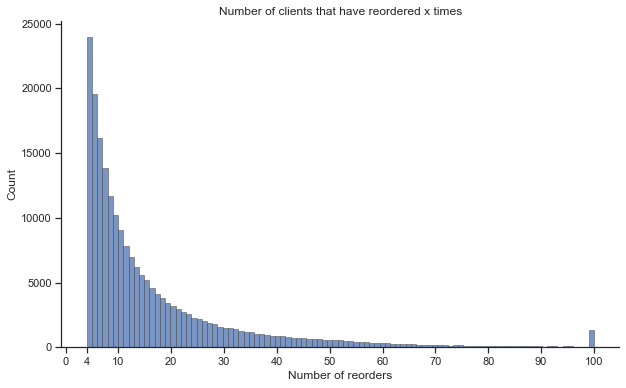

In [69]:
f, ax = plt.subplots(figsize=(10, 6))
sns.despine(f)

unique_reorders = len(orders.groupby('user_id').order_id.count().unique())

# Counting the number of reorders for all the clients in the dataset
sns.histplot(
    orders.groupby('user_id').order_id.count(),
    stat="count",
    palette="light:m",
    bins=unique_reorders,
    edgecolor=".3",
    linewidth=.5
).set(title="Number of clients that have reordered x times")
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([0,4,10,20,30,40,50,60,70,80,90,100])
ax.set(xlabel="Number of reorders",
       ylabel="Count")
plt.show()

As expected, we have between 4 and 100 orders for each client (in the complete dataset).

We can check the same thing for the training and testing sets separately.

In [14]:
print(orders[orders.eval_set == 'train'].duplicated(subset='user_id').unique())
print(orders[orders.eval_set == 'test'].duplicated(subset='user_id').unique())

[False]
[False]


In the `train` and `test` sets, we only have 1 order per client.

In [12]:
# Number of different items ordered by clients

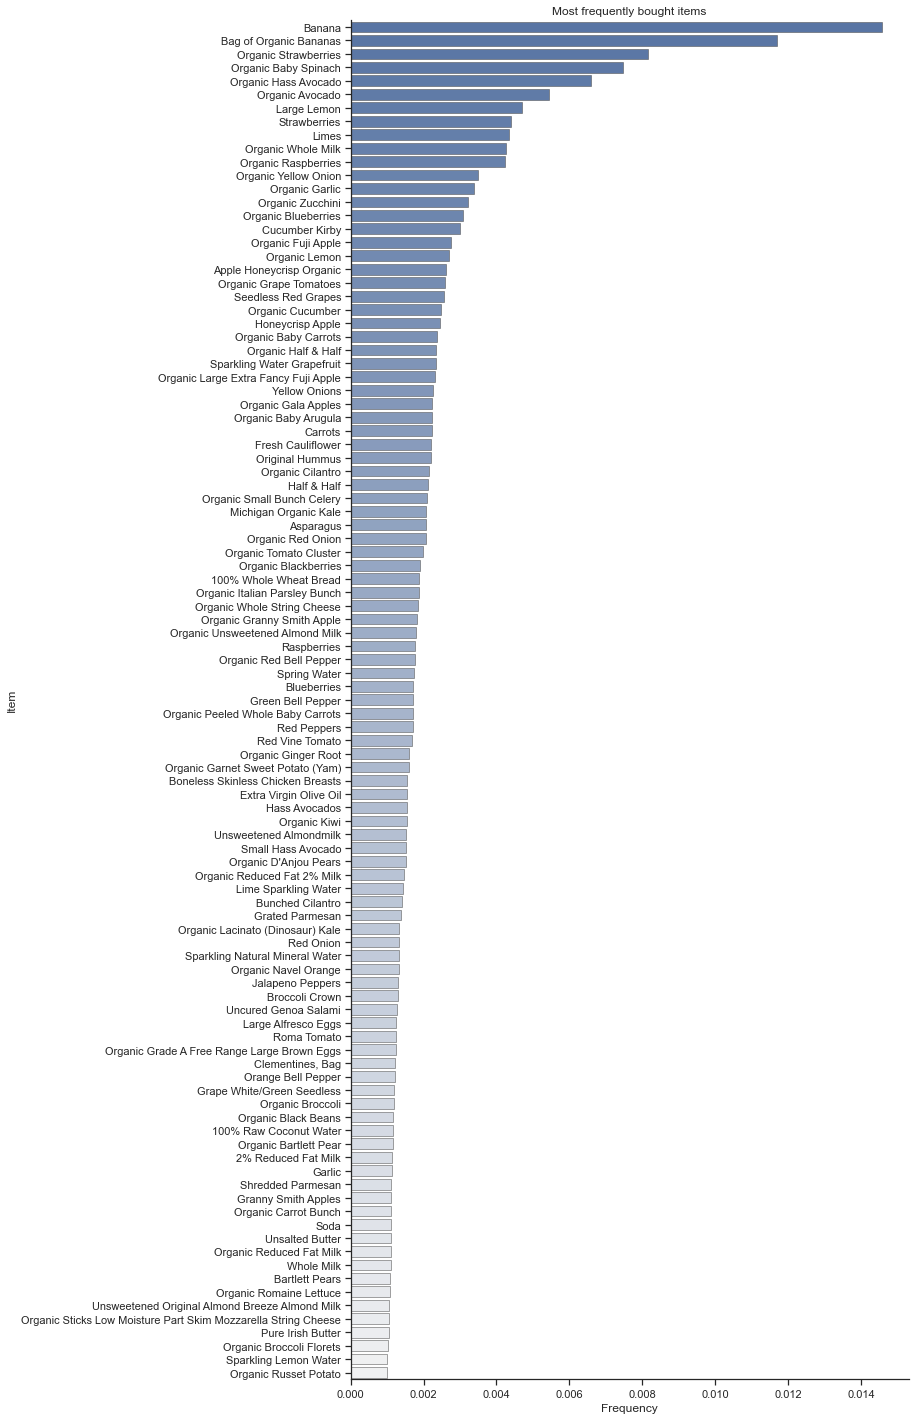

In [136]:
# Item frequency distribution

# Create the DataFrame with the frequency of appearance of ordered items
order_count = len(op_prior)
item_freq = op_prior.product_id.value_counts()
item_freq = pd.DataFrame(item_freq.reset_index())
item_freq.rename(columns={'product_id':'n_occ', 'index':'product_id'}, inplace= True)
item_freq['frequency'] = item_freq['n_occ']/order_count
item_freq = item_freq.merge(products, on='product_id')

# Plot
f, ax = plt.subplots(figsize=(10, 25))
sns.despine(f)

unique_reorders = len(orders.groupby('user_id').order_id.count().unique())

sns.barplot(
    x='frequency',
    y='product_name',
    data=item_freq[item_freq.frequency>10e-4], # Only plot the 101 most frequently bought items
    palette="light:b_r",
    edgecolor=".3",
    linewidth=.5
).set(title="Most frequently bought items")
ax.set(xlabel="Frequency",
       ylabel="Item")
plt.show()

Fruits and vegetable, including organic fruits and vegetables, are the most popular among Instacart users.

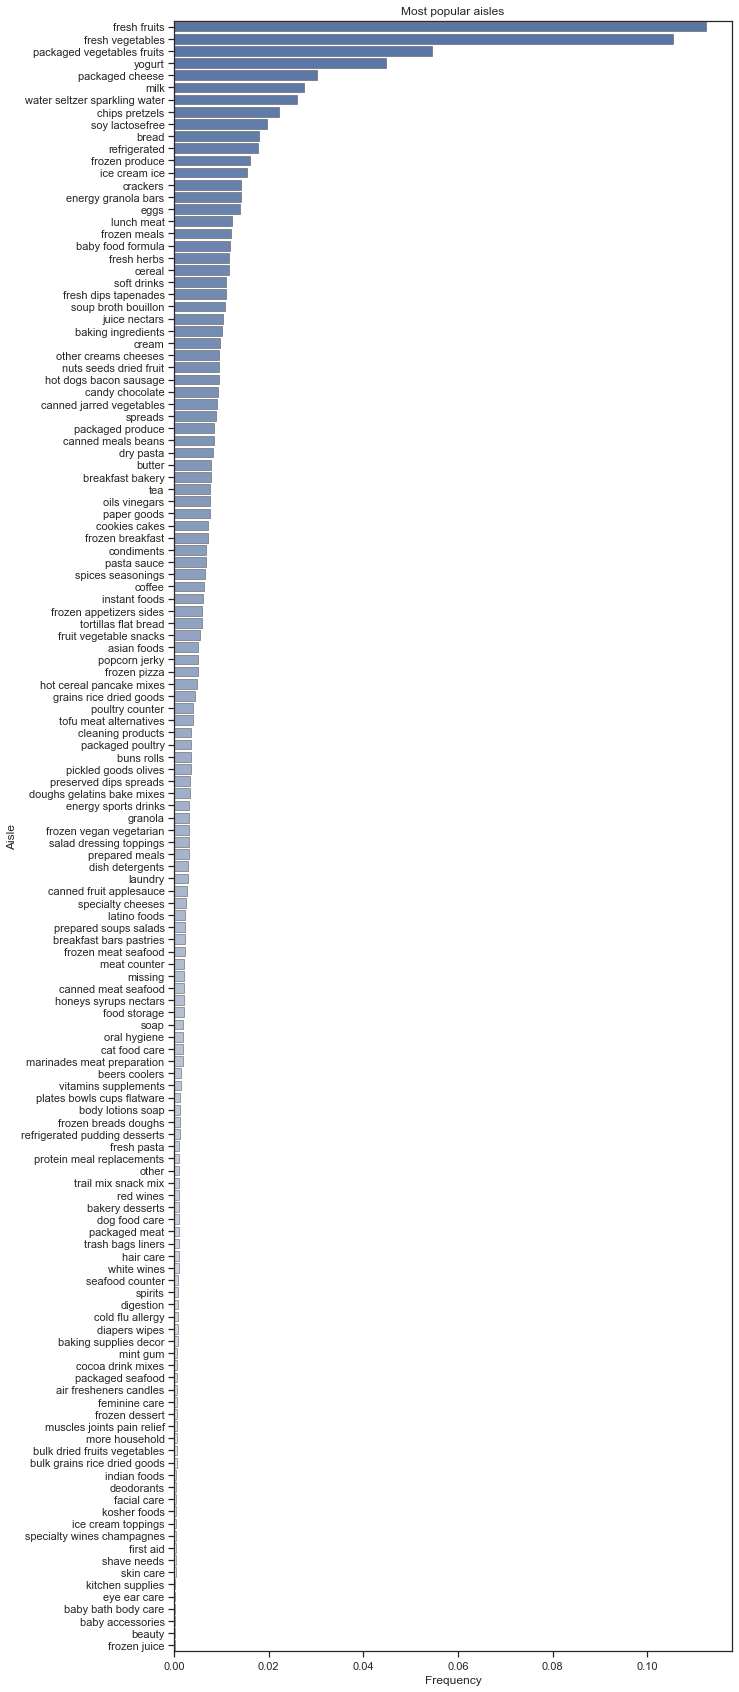

In [129]:
# Most popular aisles

aisle_freq = item_freq.groupby('aisle_id').n_occ.sum().sort_values(ascending=False)
aisle_freq = pd.DataFrame(aisle_freq.reset_index())
aisle_freq['frequency'] = aisle_freq['n_occ']/order_count
aisle_freq = aisle_freq.merge(aisles, on='aisle_id')

f, ax = plt.subplots(figsize=(10, 30))

unique_reorders = len(orders.groupby('user_id').order_id.count().unique())

sns.barplot(
    x='frequency',
    y='aisle',
    data=aisle_freq,
    palette="light:b_r",
    edgecolor=".3",
    linewidth=.5
).set(title="Most popular aisles")
ax.set(xlabel="Frequency",
       ylabel="Aisle")
plt.show()

We see that fresh fruits and vegetables are the most popular aisles on Instacart, which is logical since they contain products that are more frequently ordered than other shelf stable products.

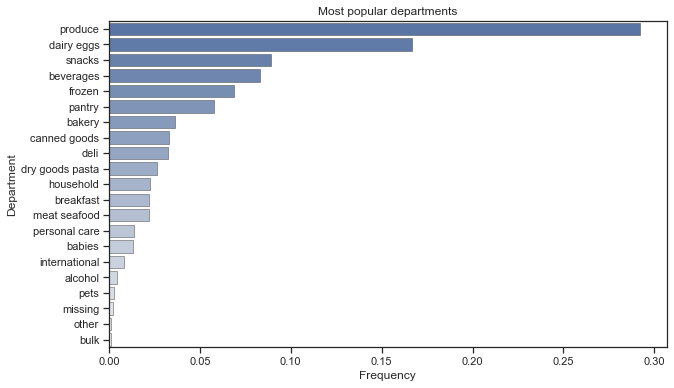

In [127]:
# Most popular departments

dep_freq = item_freq.groupby('department_id').n_occ.sum().sort_values(ascending=False)
dep_freq = pd.DataFrame(dep_freq.reset_index())
dep_freq['frequency'] = dep_freq['n_occ']/order_count
dep_freq = dep_freq.merge(departments, on='department_id')

f, ax = plt.subplots(figsize=(10, 6))

unique_reorders = len(orders.groupby('user_id').order_id.count().unique())

sns.barplot(
    x='frequency',
    y='department',
    data=dep_freq,
    palette="light:b_r",
    edgecolor=".3",
    linewidth=.5
).set(title="Most popular departments")
ax.set(xlabel="Frequency",
       ylabel="Department")
plt.show()

We see that food items (fresh or shelf stable) are the most popular departments on Instacart.

## Next 

See either `SD201-Instacart-AssociationRuleMining` or `SD201-Instacart-MultiLabelClassification` notebooks.